##**HOMEWORK 06**
### IANNWTF
###Group 02

In [3]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import time 

# This notebook is based on the fashion_mnist_gradients-notebook from the courseware

### Load the dataset.

In [4]:
# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


BATCH=128
IMG_SIZE=32

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
# Function to plot some images from the data 
def plot_images(images, num_labels, name_label, row, col):
  ''' Creates a visualization of a given amount of images and match their numeric labels 
  to the respective name label given in a string list.

  Arguments:
  ---------
  images (ndarray) = a set of iterable images.
  num_labels (ndarray) = a set of numeric labels.
  name_label (list) = a list of ordered string names matching the numeric labels.
  row (int) = amount of rows.
  col (int) = amount of columns.
  '''

  fig, ax = plt.subplots(row,col, figsize = (18,8))
  fig.tight_layout(h_pad=2.5)
  ax = ax.flatten()

  for i in range(row * col):
    # Match the train_labels with their names labels
    for j, value in enumerate(name_label):
      if j == num_labels[i]:
        lbl = value
    # take an image, its label and corresponding shape.
    img = images[i]
    shp = images[i].shape

    # plot the image and corresponding information
    ax[i].imshow(img)
    ax[i].title.set_text(f'{lbl} \n{shp}')
    ax[i].axis("off")

### Visualize the dataset.

<class 'numpy.ndarray'>
(50000, 32, 32, 3) (50000, 1)
Image size = (32, 32, 3)
Minimun = 0, 
Maximun = 255
(10000, 32, 32, 3) (10000, 1)


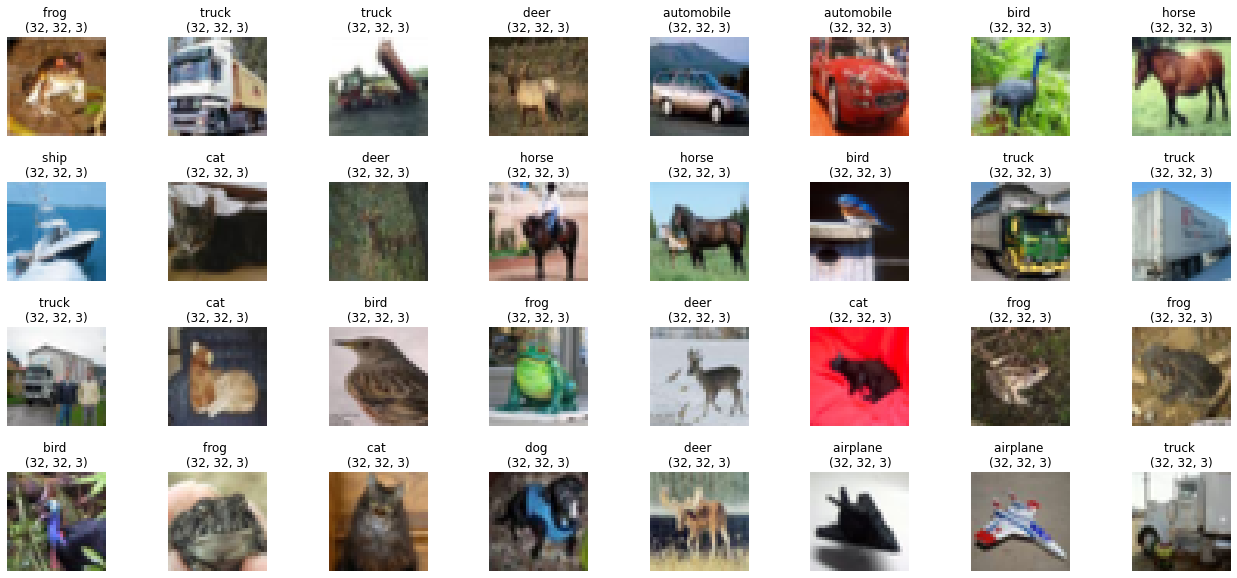

In [6]:
print(type(train_images))
print(train_images.shape, train_labels.shape)
print(f'Image size = {train_images[0].shape}')
print(f'Minimun = {np.min(train_images[0])}, \nMaximun = {np.max(train_images[0])}')
print(test_images.shape, test_labels.shape)

# Set the label names for the images
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize some of the images
plot_images(train_images, train_labels, labels, 4, 8)

### Build the TensorFlow dataset: Input pipeline
Two different training datasets are build. One without data normalization and one with pixels values centered around zero.

In [7]:
def process(dataset,labels):

  dataset_images = tf.data.Dataset.from_tensor_slices(dataset)

  #normalize the data
  dataset_images=dataset_images.map(lambda x:tf.cast(2*(x/255)-1,tf.float32))

  #the labels are in the wrong shape (x,1), transform them to (x)
  labels=labels.reshape((-1))

  labels = tf.data.Dataset.from_tensor_slices(labels)

  #one hot encode, there are 10 different labels
  labels = labels.map(lambda t : tf.one_hot(t, 10))

  data=tf.data.Dataset.zip((dataset_images, labels))
  
  data=data.shuffle(BATCH)
  data=data.batch(BATCH)
  data=data.prefetch(tf.data.experimental.AUTOTUNE)
  return data

train_dataset = process(train_images,train_labels)
test_dataset = process(test_images,test_labels)

### Build the DenseNet
Done as explained in the exercise sheet.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class TransitionLayer(Layer):
  
  def __init__(self,activation,seed,regularizer,channel_number):
    super(TransitionLayer,self).__init__()
    self.hidden_layers=[
        (False,tf.keras.layers.Conv2D(filters=channel_number,kernel_size=1,activation=None,
                                      kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                      kernel_regularizer=tf.keras.regularizers.l2(regularizer)
                                      )),
        (True,tf.keras.layers.BatchNormalization()),
        (False,activation),
        (False,tf.keras.layers.AveragePooling2D(strides=2))
    ]

  @tf.function
  def call(self,x,training=True):
        # Define the forward step.
        for (tr,layer) in self.hidden_layers:
          x = layer(x, training) if tr else layer(x)
        return x
         
class DenseBlock(Layer):
  
  def __init__(self,activation,seed,regularizer,channel_number):
    super(DenseBlock,self).__init__()
    self.hidden_layers=[
        (tf.keras.layers.Conv2D(filters=int(channel_number),kernel_size=3,activation=None,padding="same",
                                      kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                      kernel_regularizer=tf.keras.regularizers.l2(regularizer)
                                      ),
        tf.keras.layers.BatchNormalization(),
        activation),
        (tf.keras.layers.Conv2D(filters=int(channel_number*2),kernel_size=3,activation=None,padding="same",
                                      kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                      kernel_regularizer=tf.keras.regularizers.l2(regularizer)
                                      ),
        tf.keras.layers.BatchNormalization(),
        activation),
        (tf.keras.layers.Conv2D(filters=int(channel_number*2),kernel_size=3,activation=None,padding="same",
                                      kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                      kernel_regularizer=tf.keras.regularizers.l2(regularizer)
                                      ),
        tf.keras.layers.BatchNormalization(),
        activation),
        (tf.keras.layers.Conv2D(filters=int(channel_number),kernel_size=3,activation=None,padding="same",
                                      kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                      kernel_regularizer=tf.keras.regularizers.l2(regularizer)
                                      ),
        tf.keras.layers.BatchNormalization(),
        activation),
    ]

  @tf.function
  def call(self,x,training=True):
        # Define the forward step.
        for (layer,batch,activ) in self.hidden_layers:
          y = layer(x)
          y = activ(batch(y,training))
          x = tf.keras.layers.concatenate([x,y])
        return x

class DenseNet(Model):
  def __init__(self,activation,seed,regularizer,base_size,block_number):
    super(DenseNet,self).__init__()
    self.inputLayer=tf.keras.layers.Conv2D(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                           filters=base_size,kernel_size=3,activation=activation,padding="same",
                                      kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                      kernel_regularizer=tf.keras.regularizers.l2(regularizer)
                                      )
    self.blocks=[]
    for i in range(block_number-1):
      self.blocks.append((DenseBlock(activation,seed,regularizer,base_size),TransitionLayer(activation,seed,regularizer,base_size)))
    self.lastBlock=DenseBlock(activation,seed,regularizer,base_size)
    self.globalPool=tf.keras.layers.GlobalAveragePooling2D()
    self.hidden=tf.keras.layers.Dense(units=512,activation=activation,
                                           kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                           kernel_regularizer=tf.keras.regularizers.l2(reg))
    self.dropout=tf.keras.layers.Dropout(rate=0.5)
    self.outputLayer=tf.keras.layers.Dense(units=10,activation=tf.keras.activations.softmax,
                                           kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                           kernel_regularizer=tf.keras.regularizers.l2(reg)
                      )
  
  @tf.function
  def call(self,x,training=True):
    x=self.inputLayer(x)
    for (block,trans) in self.blocks:
      x=trans(block(x,training),training)
    x=self.lastBlock(x,training)
    x=self.globalPool(x)
    x=self.dropout(self.hidden(x),training)
    return self.outputLayer(x)     
  

### Build the ResNet
Done as explained in the exercise sheet.

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# Define the residual blocks
class ResidualBlock(Model):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    
    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=1, padding = 'valid', activation=None)
    self.batch_n1 = tf.keras.layers.BatchNormalization()
    
    self.conv2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding = 'same', activation=None)
    self.batch_n2 = tf.keras.layers.BatchNormalization()

    # self.conv3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding = 'same', activation=None)
    # self.batch_n3 = tf.keras.layers.BatchNormalization()

    self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding = 'same', activation=None)
    self.batch_n4 = tf.keras.layers.BatchNormalization()

    self.shortcut = tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding = 'same', activation=None)
    self.shortcut_norm = tf.keras.layers.BatchNormalization()

    self.relu = tf.nn.leaky_relu
    self.dropout_2 = tf.keras.layers.Dropout(rate=0.3)
  
  @tf.function
  def call(self, x, training = True):
    input_copy = tf.identity(x)
    x = self.conv1(x)
    x = self.batch_n1(x, training)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_n2(x, training)
    x = self.relu(x)
    x = self.dropout_2(x) 
    # x = self.conv3(x)
    # x = self.batch_n3(x)
    # x = self.relu(x)
    x = self.conv4(x)
    x = self.batch_n4(x)
    # convolutes over the original input 
    skip = self.shortcut(input_copy)
    skip = self.shortcut_norm(skip, training)
    # add result of last convolution4 and the convoluted original input (skip)
    x = x + skip
    x = self.relu(x)

    return x


class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()

        # Create five residual blocks
        self.conv_block = [ResidualBlock() for _ in range(5)]
        # Define the layers as follows.
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                             padding = 'valid',
                                             activation=None,
                                             input_shape=(32,32,3)
                                             )
        
        self.conv_1_batch_n = tf.keras.layers.BatchNormalization()
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                    strides = (1,1))

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(10,
                                                  activation = tf.keras.activations.softmax
                                                  )
  
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.relu = tf.nn.leaky_relu
    
    @tf.function
    def call(self, x, training=True):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.conv_1_batch_n(x, training)
        x = self.relu(x)
        x = self.max_pool_1(x)
        
        # Iterate over the convolution blocks created earlier
        for j in self.conv_block:
          x = j(x, training)

        x = self.global_pool(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [11]:
#taken from the courseware notebook

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
def plot(train_losses,test_losses,test_accuracies):
  plt.figure()
  x = list(range(len(train_losses)))
  line1, = plt.plot(x, train_losses, label='training')
  line2, = plt.plot(x, test_losses, label='test')
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.title(f'Total Acuraccy: {np.max(test_accuracies)}')
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.show()

In [12]:
# as in the original notebooks
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input,training=False)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss,test_accuracy 

def train_model(model, train_dataset, test_dataset, loss_function, optimizer, epochs):
    train_losses = []
    test_losses=[]
    test_accuracies=[]
    running_average_factor = 0.95
    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print('Epoch: __ ' + str(epoch))

        train_dataset = train_dataset.shuffle(buffer_size=128)
        test_dataset = test_dataset.shuffle(buffer_size=128)
        #training
        running_average = 0
        for (input,target) in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        train_losses.append(running_average)
        #testing
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        if epoch>0 and epoch%5==0:
          plot(train_losses,test_losses,test_accuracies)

        
    plot(train_losses,test_losses,test_accuracies)
    
    return train_losses


### Training DenseNet


Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1344      
_________________________________________________________________
dense_block (DenseBlock)     multiple                  395424    
_________________________________________________________________
transition_layer (Transition multiple                  16368     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  395424    
_________________________________________________________________
transition_layer_1 (Transiti multiple                  16368     
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  395424    
_________________________________________________________________
transition_layer_2 (Transiti multiple                  16

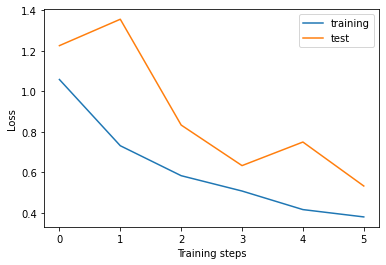

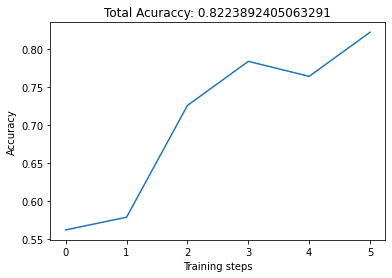

Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10


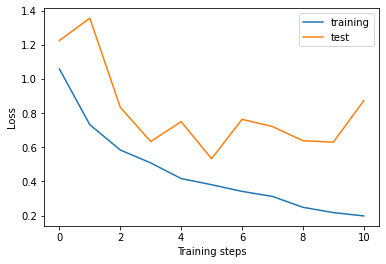

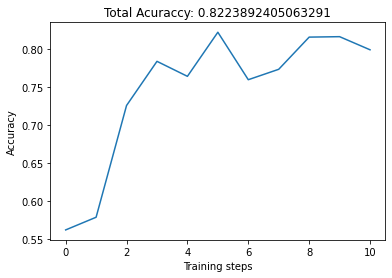

Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15


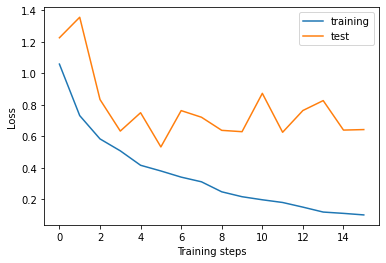

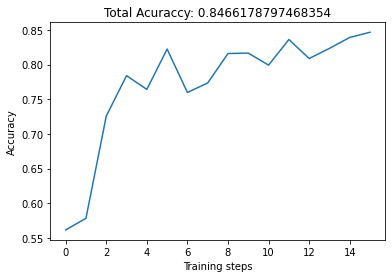

Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20


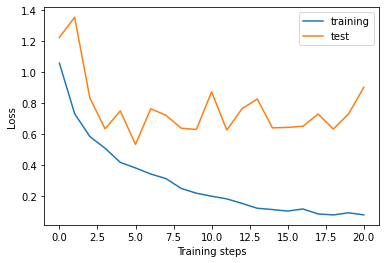

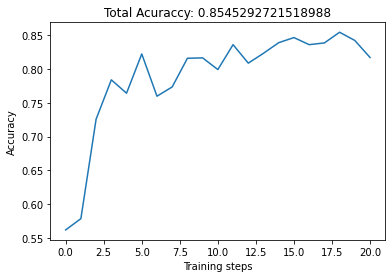

Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25


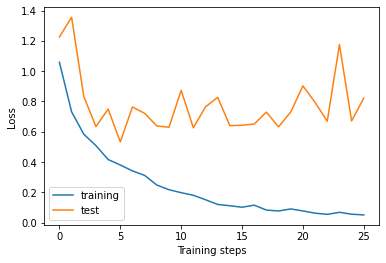

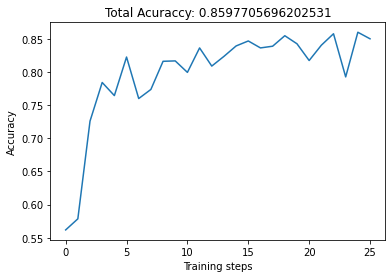

Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29


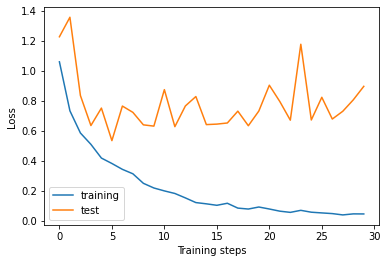

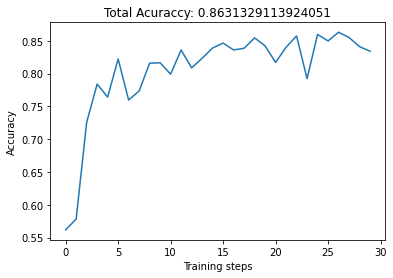


This training took: 30 minutes and 24.9045889377594 seconds.


In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001
# reset the global seed after each model initialization to create identical starting weights
# change global seed for different weights
global_seed = 5
seed = 3
reg=0.05 #regularization-rate
drop=0.5 #dropout-rate

# Set the time
start = time.time()

# same loss and optimizer as usual
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

tf.random.set_seed(global_seed)
#model = ResNet(activation=tf.keras.activations.relu, seed=seed,regularizer=0.05,base_size=16,block_number=4)
model = DenseNet(activation=tf.keras.activations.relu, seed=seed,regularizer=0.05,base_size=48,block_number=4)
model.build((BATCH,IMG_SIZE,IMG_SIZE,3))
print(model.summary())
train_losses = train_model(model, train_dataset, test_dataset, cross_entropy_loss, optimizer, num_epochs)


# Keep track of the time 
end = time.time()
duration = end - start

print(f'\nThis training took: {int (duration / 60)} minutes and {(duration % 60)} seconds.')


# Train the Resnet

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5


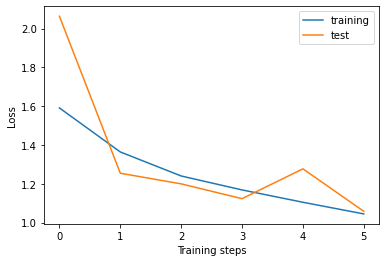

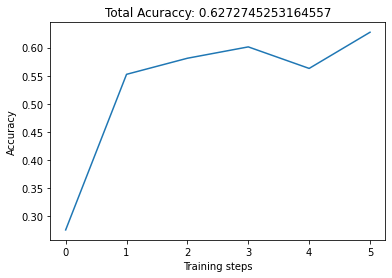

Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10


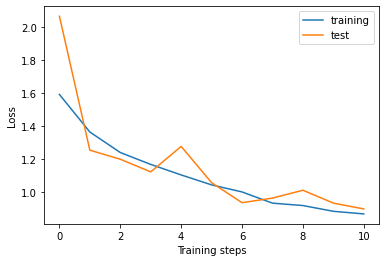

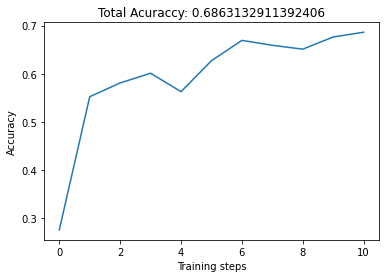

Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15


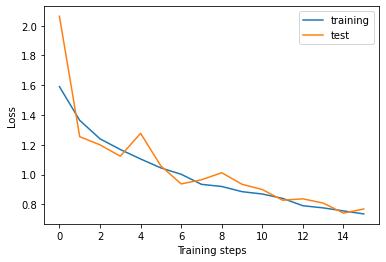

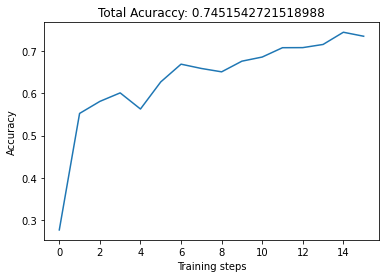

Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20


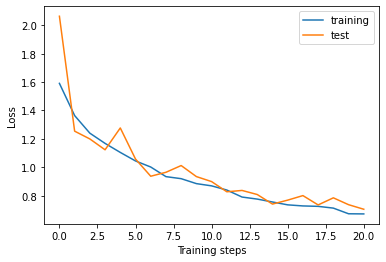

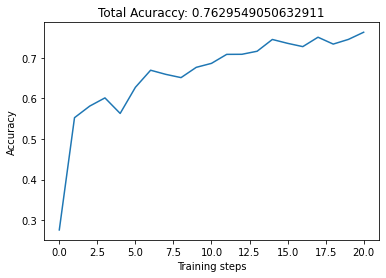

Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25


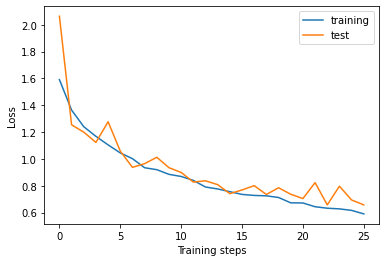

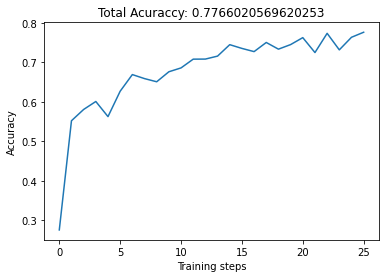

Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
Epoch: __ 30


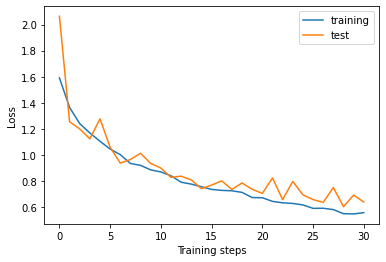

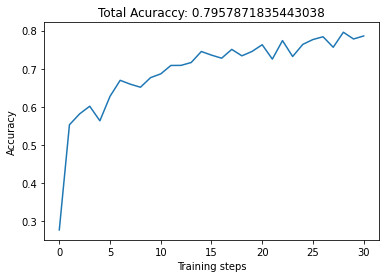

Epoch: __ 31
Epoch: __ 32
Epoch: __ 33
Epoch: __ 34
Epoch: __ 35


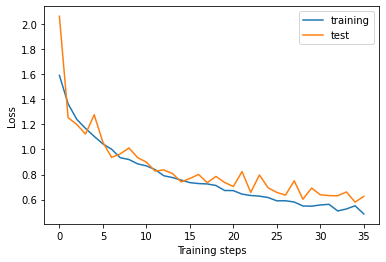

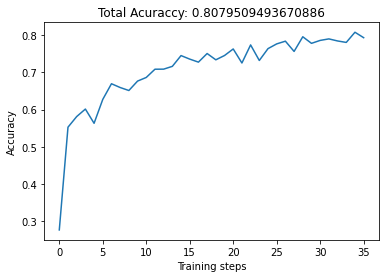

Epoch: __ 36
Epoch: __ 37
Epoch: __ 38
Epoch: __ 39
Epoch: __ 40


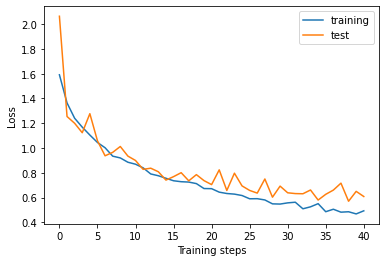

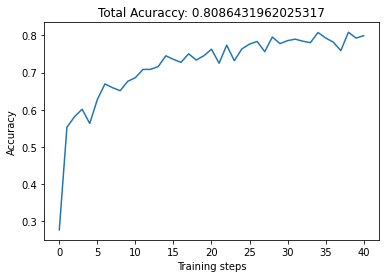

Epoch: __ 41
Epoch: __ 42
Epoch: __ 43
Epoch: __ 44
Epoch: __ 45


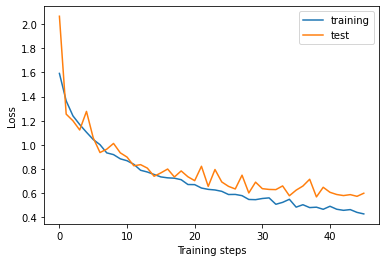

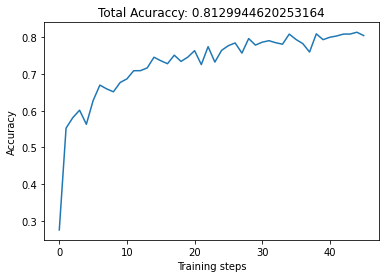

Epoch: __ 46
Epoch: __ 47
Epoch: __ 48
Epoch: __ 49


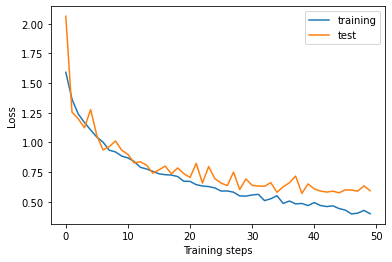

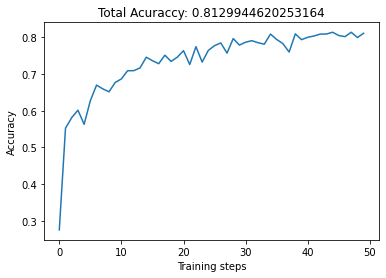

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block (ResidualBloc multiple                  115104    
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  118176    
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  118176    
_________________________________________________________________
residual_block_3 (ResidualBl multiple                  118176    
_________________________________________________________________
residual_block_4 (ResidualBl multiple                  118176    
_________________________________________________________________
conv2d_20 (Conv2D)           multiple                  896       
_________________________________________________________________
batch_normalization_20 (Batc multiple                  128   

In [15]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 50
learning_rate = 0.0001
running_average_factor = 0.95

# Set the time
start = time.time()

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)


train_losses = train_model(model, train_dataset, test_dataset, cross_entropy_loss, optimizer, num_epochs)

# Keep track of the time 
end = time.time()
duration = end - start

print(model.summary())
print(f'\nThis training took: {int (duration / 60)} minutes and {(duration % 60)} seconds.')

#Analysing and comparing models

After having trained both models on the same data and having run them both for 30 epochs, we reached the following conclusions:

1. Even though we obtained a higher accuracy using the DenseNet architecture (86%), this one was more prone to overfitting. However, it was faster to train compared to ResNet and even with more parameters.
2. On the other had, we used dropout when training the Resnet which accounts for the fact that it did not overfit much as we can see in the ResNet graphs. However, we can see that ResNet needs twice the time as DensNet and does not reach the same accuracy.
3. As to the previous model, the one we trained for the previous homework, we found that it reached 85% accuracy just by using regularizations techniques such as dropout and batch normalization. Thus, based on these results, we can say that, implementing both models and their respective architectures did not make much of a difference regarding the accuracy of the model. However, with better parameters and a carefull selection of regularization techniques we could have improve them. 